<a href="https://colab.research.google.com/github/rangedayo/first-repository/blob/master/Main_quest_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

본 과제는 Spaceship Titanic 데이터셋을 사용하여 탑승객이 이동했는지(Transported) 여부를 예측하는 모델을 만드는 것을 목표로 한다.
데이터를 살펴보며 각 feature의 특징에 따라 결측치와 이상치를 처리한 뒤, '이동'과의 연관성이 어떻게 되는지 파악하였고, 이후 XGBoost 모델을 이용해 예측 성능을 확인하였다.

#목차
1. 결측치, 이상치 확인
2. 컬럼별 특징 파헤치기
3. feature 정리
4. 모델 학습 및 평가
5. 회고

In [1]:
# 파일 불러오기
from google.colab import files
import pandas as pd

uploaded = files.upload()  # 파일 선택창 뜸

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_id = pd.read_csv("test.csv")["PassengerId"].copy()

Saving test.csv to test (11).csv
Saving train.csv to train (11).csv


# 결측치, 이상치 확인
feature 분석에 앞서서 결측치, 이상치를 먼저 확인하는 게 순서일 듯하다.

## 결측치 확인

In [2]:
train.shape

(8693, 14)

In [3]:
train.isnull().sum()

,0
PassengerId,0
HomePlanet,201
CryoSleep,217
Cabin,199
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208


In [4]:
(train.isnull().sum() / len(train)).sort_values(ascending=False)

,0
CryoSleep,0.024963
ShoppingMall,0.023927
VIP,0.023352
HomePlanet,0.023122
Name,0.023007
Cabin,0.022892
VRDeck,0.021627
Spa,0.021051
FoodCourt,0.021051
Destination,0.020936


결측치가 컬럼마다의 전체 데이터에 비해 몇 %인지 나온다.

1~2%이면, 처리해서 사용<br>
30% 이상, 제거 고려<br>

1~2% 내외이고, 결측치 비율이 전체적으로 고루고루 잡혀있어 특정 컬럼에 쏠려있는 데이터셋은 아니다. 보통 2% 정도의 결측치면 삭제/대체해도 무리 없다고 한다.
그래서 안전하게 단순 대체를 해보려고 한다.

In [5]:
# 수치형 / 범주형 컬럼 분리
num_cols = train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = train.select_dtypes(include=["object", "bool"]).columns

# 목표 변수 제거
cat_cols = cat_cols.drop("Transported")

for col in num_cols:
    median = train[col].median()
    train[col].fillna(median, inplace=True)
    test[col].fillna(median, inplace=True)

for col in cat_cols:
    train[col].fillna("Missing", inplace=True)
    test[col].fillna("Missing", inplace=True)

/tmp/ipython-input-1219022619.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(median, inplace=True)
/tmp/ipython-input-1219022619.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [6]:
train.isnull().sum().sum()
test.isnull().sum().sum()

np.int64(0)

문자형의 대체값으로 "Missing"이 들어갔는데, Missing은 실제로 모델에서‘다른 값으로 작용한다고 한다. 특히 트리 기반 모델(XGBoost, LightGBM) 에서 의미가 있다.

결측값이 있는지 확인해보니 0이 떴다. 잘 해결되었다.

## 이상치 확인

In [7]:
import pandas as pd

# 수치형 컬럼만 뽑기. 그래야 이상치 계산이 되니까
num_cols = train.select_dtypes(include=["int64","float64"]).columns

# IQR 이상치 계산 함수
def count_outliers_iqr(s):
    s = s.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    out_cnt = ((s < lower) | (s > upper)).sum()
    out_pct = out_cnt / len(s) * 100
    return out_cnt, out_pct, lower, upper

# 3) 컬럼별 결과 표 만들기
rows = []
for col in num_cols:
    out_cnt, out_pct, lower, upper = count_outliers_iqr(train[col])
    rows.append([col, round(out_cnt, 0), round(out_pct, 2), round(lower, 2), round(upper, 2)])

outlier_df = pd.DataFrame(rows, columns=["컬럼", "이상치개수", "이상치비율(%)", "하한", "상한"])
outlier_df.sort_values("이상치개수", ascending=False)

,컬럼,이상치개수,이상치비율(%),하한,상한
2,FoodCourt,1916,22.04,-91.5,152.5
1,RoomService,1906,21.93,-61.5,102.5
3,ShoppingMall,1879,21.62,-33.0,55.0
5,VRDeck,1849,21.27,-60.0,100.0
4,Spa,1833,21.09,-79.5,132.5
0,Age,162,1.86,-5.5,62.5


여기서 보면 이상치 비율이 꽤 높은 컬럼의 특징을 보니,<br>
푸드코트, 룸서비스, 쇼핑몰, VRdeck(가상현실체험), 스파 등 돈 쓰는 여가 생활과 관련된 컬럼이다.

이상치를 조정해야하나 말아야 하나 고민이 들 때는 해당 컬럼의 특징이 이상치에 영향을 주는 건 아닐지, 이상치가 높다고 단순히 제거해야 할 부분일지는 이상치가 주는 의미에 대해 고민을 좀 더 해봐야 한다고 했다.

내가 판단하기로는 부자가 해당 서비스를 잘 이용하고 싶어서 돈을 펑펑 쓴거일수도 있으니, 그대로 놔둬보기로 한다.

https://excelsu.tistory.com/26 참고

# 컬럼별 특징 파헤치기

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


문자형이 절반 정도 있다. 하나하나 다 원-핫 인코딩을 할 것인지 여부 + 모델 학습에 필요없는 컬럼 제거하기 등등, 이제 목표 변수인 Transported와 연관된 컬럼들을 추려보고자 한다.
<br><br>

PassengerId : 승객의 고유 ID<br>
Name : 승객 이름<br>
HomePlanet : 승객 출신 행성<br>
Destination : 승객의 최종 목적지 행성<br>
Age : 승객 나이<br>
CryoSleep : 냉동 수면 상태 여부<br>
VIP : VIP 고객인지 여부<br>
Cabin : 승객의 객실 정보<br>
RoomService : 객실 내 서비스에 쓴 금액<br>
FoodCourt : 식당에서 쓴 금액<br>
ShoppingMall : 쇼핑몰에서 쓴 금액<br>
Spa : 스파에서 쓴 금액<br>
VRDeck : VR 시설에서 쓴 금액<br>

Transported : 목표 변수. 승객이 다른 차원으로 이동되었는지 여부
<br><br><br>

위 컬럼 이름만 보더라도, 추려낼 수 있는 컬럼이 있다.
- 모델 학습할 때 ID는 필요 없으므로 PassengerId 삭제.
- 승객 이름이 transported 되는지 여부에 의미를 줄지가 의문. 저번 포켓몬 구분지을 때는 이름이 영향이 있었던 것 같은데.. 여기서는 ID와 같은 계열이라고 판단하기 때문에 Name도 삭제.
<br>

그 외에도<br>

1) 승객의 출신, 나이가 transported되는 데에 어떤 영향을 줄지가 궁금하다.<br>
2) 승객의 최종 목적지가 어디인지에 따라 transported에 영향을 주지 않을까 싶다.
3) 만약 transported 여부가 재력 또는 돈을 쓴 정도에 영향을 받는다고 하면<br>
VIP, Cabin, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck 컬럼이 가지는 의미가 중요하지 않을까 생각이 든다.

추측만으로 각각의 컬럼이 주는 영향력을 판단할 수 없으니, 근거로 확인해보자.

## 1. 수치형 컬럼
Age<br>
RoomService<br>
FoodCourt<br>
ShoppingMall<br>
Spa<br>
VRDeck<br>

위 컬럼은 수치형이므로 상관계수를 통해 transported에게 어떤 영향을 미치는지 확인해보려고 한다.



### 1-1) 상관계수로 관계성 확인

In [9]:
train['Age'].corr(train['Transported'])

np.float64(-0.07423258632964795)

In [10]:
train['RoomService'].corr(train['Transported'])

np.float64(-0.2411235799029619)

In [11]:
train['FoodCourt'].corr(train['Transported'])

np.float64(0.04558341664358469)

In [12]:
train['ShoppingMall'].corr(train['Transported'])

np.float64(0.009391027784015262)

In [13]:
train['Spa'].corr(train['Transported'])

np.float64(-0.21854462654893267)

In [14]:
train['VRDeck'].corr(train['Transported'])

np.float64(-0.20487369065784614)

Age: -0.075<br>
RoomService: -0.245 <br>
FoodCourt: +0.047<br>
ShoppingMall: +0.010
Spa: -0.221<br>
VRDeck: -0.207<br>
<br>
판단 :<br>
- Age는 약하게 음수라서 거의 영향이 없다고 봐도 무방하다.
- RoomService, Spa, VRDeck은 음의 상관관계로 돈을 많이 쓰는 사람일수록 trarnsported가 덜 되는 편이라는 것을 추측해볼 수 있다.
- FoodCourt, ShoppingMall은 약한 양의 관계라서 이것 또한 영향이 거의 없다고 봐도 될 것 같다.

- 돈을 얼마나 썼는지의 여부가 transported에 영향을 주는 거라면, 금액의 액수에 따라 transported를 따져볼 수 있는 컬럼을 만드는 게 좋다고 한다.
<br>
<br>

결론 :<br>
상관계수를 통해 각 컬럼과 transported와의 관계를 알았지만, 영향이 미미하다 할지라도 다른 컬럼과 결합했을 때 결과적으로 transported에 영향을 줄 수도 있다고 생각해 다 남기기로 했다. + '금액합계' 컬럼을 추가한다.






### 1-2) 수치형 컬럼의 치우침 정도 확인

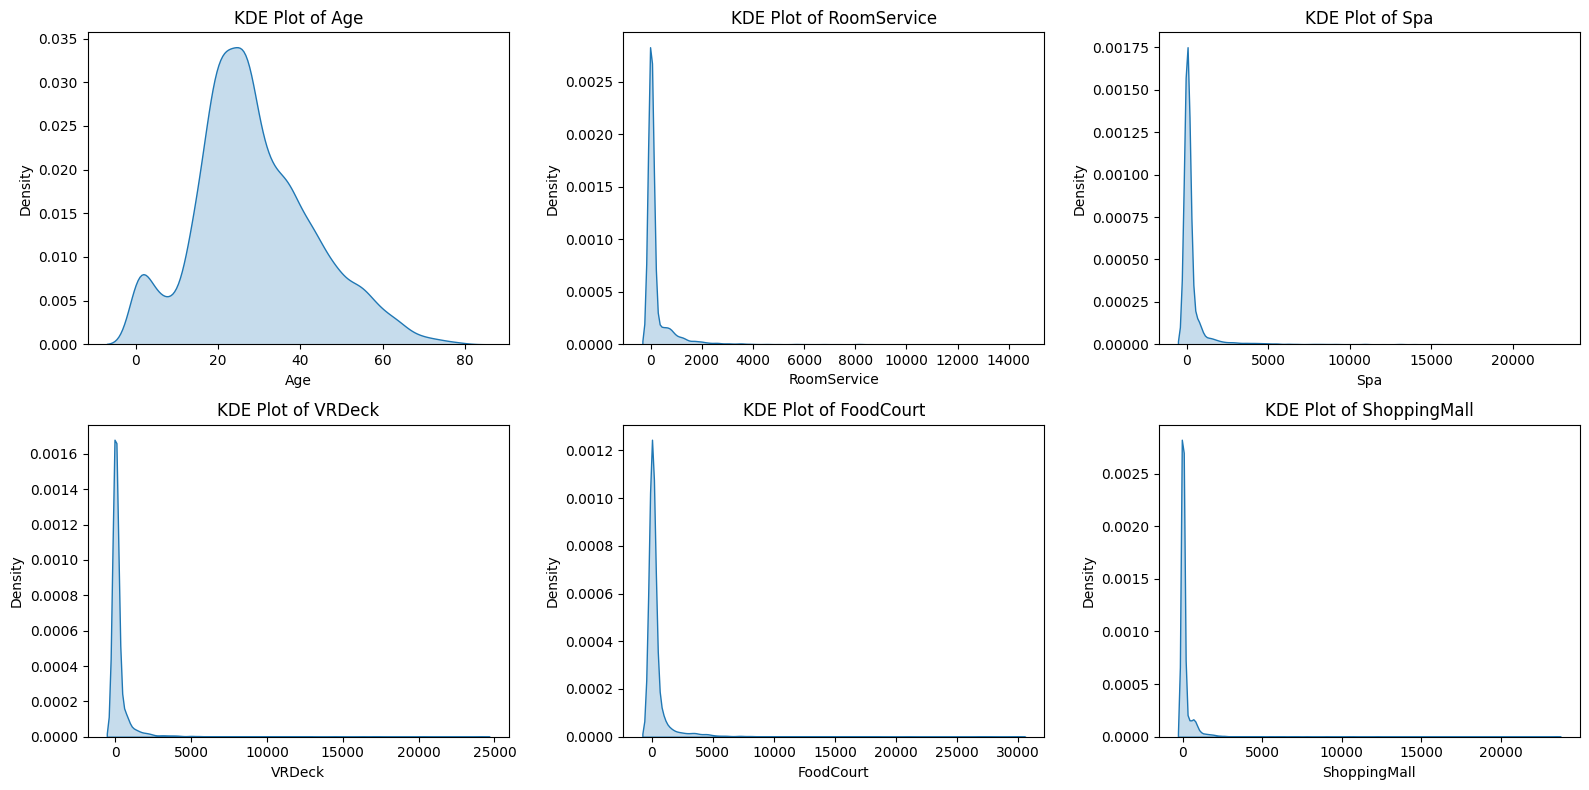

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 그릴 컬럼 목록
cols = ['Age', 'RoomService', 'Spa', 'VRDeck', 'FoodCourt', 'ShoppingMall']

# 2행 3열 subplot 생성
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# 각 subplot에 KDE plot 그리기
for ax, col in zip(axs.flatten(), cols):
    sns.kdeplot(
        data=train,
        x=col,
        ax=ax,
        fill=True      # 면적 채우기 (원하면 제거 가능)
    )
    ax.set_title(f'KDE Plot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

# 레이아웃 정리
plt.tight_layout()
plt.show()

Age 컬럼은 치우침이 크지 않은데, 다른 그래프는 꼬리가 길다.<br>
즉, log1p 변환이 필요하다는 뜻이다.

In [16]:
# 컬럼들 로그 변환시킴
money_cols = ['RoomService', 'Spa', 'VRDeck', 'FoodCourt', 'ShoppingMall']

for col in money_cols:
    train[col] = np.log1p(train[col])
    test[col]  = np.log1p(test[col])

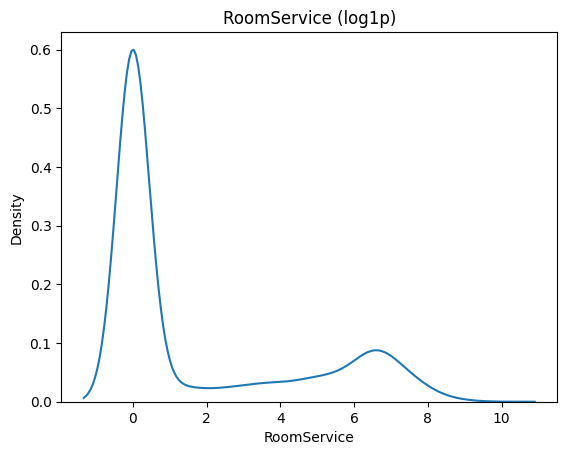

In [17]:
# 로그 변환 됐는지 확인
sns.kdeplot(train['RoomService'])
plt.title('RoomService (log1p)')
plt.show()

# 2. 범주형 컬럼
CryoSleep<br>
HomePlanet<br>
Cabin<br>
Destination<br>
VIP

위 컬럼은 범주형이므로 그래프를 통해 transported에게 어떤 영향을 미치는지 확인해보려고 한다.

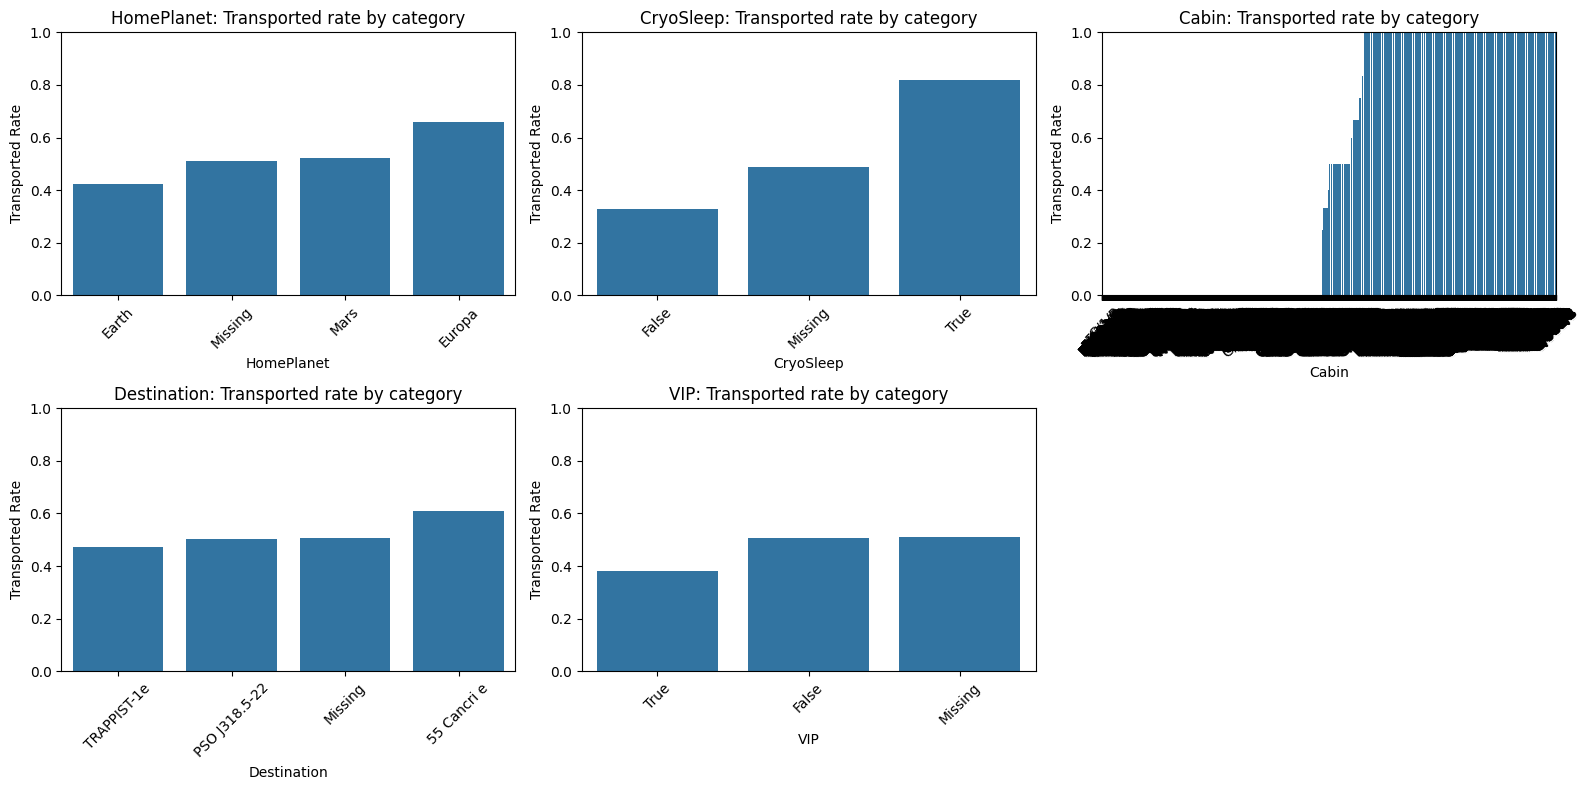

In [18]:
# 1) EDA 전용으로 "원본 train.csv" 다시 로드
raw_train = pd.read_csv("train.csv")

target = "Transported"
cat_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

# 2) (안전장치) 실제로 존재하는 컬럼만 사용
cat_cols = [c for c in cat_cols if c in raw_train.columns]

# 3) 결측치 처리(EDA용) + 타입 정리
t_all = raw_train.copy()
for c in cat_cols:
    t_all[c] = t_all[c].fillna("Missing").astype(str)

# target은 bool일 수 있으니 평균 계산을 위해 int로
t_all[target] = t_all[target].astype(int)

# 4) subplot 생성 (2행 3열)
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# 5) subplot 하나씩 채우기
for ax, col in zip(axs.flatten(), cat_cols):
    grp = (
        t_all.groupby(col)[target]
             .mean()
             .reset_index()
             .sort_values(target)
    )

    sns.barplot(
        data=grp,
        x=col,
        y=target,
        ax=ax
    )

    ax.set_title(f'{col}: Transported rate by category')
    ax.set_xlabel(col)
    ax.set_ylabel('Transported Rate')
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)

# 6) 남는 subplot 숨기기
for ax in axs.flatten()[len(cat_cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [19]:
len(raw_train['Cabin'].unique())   # 고유값이 총 6561개

6561

컬럼마다 카테고리별 transported 비율을 보여주는 그래프다.
<br><br>

HomePlanet :<br>
eupora > mars > earth > missing 별로 transported 낮아짐
<br><br>
CryoSleep :<br>
냉동 수면한 사람이 transported 높음<br>
transported 차이가 확연히 뚜렷함 → 강력한 영향을 주는 존재일 수 있음
<br><br>
Cabin :<br>
고유값이 너무 많아서 x축 라벨이 전부 겹쳐서 저런 형태의 그래프를 보여주는 것<br>
문제는 이 컬럼 그대로 원핫 인코딩하면 차원 폭발해버린다 → Deck/Side로 분해해서 원핫인코딩으로 진행한다.
<br><br>
그럼<br>
왜 Cabin 컬럼을 Deck / Side로 나눠서 원핫 인코딩하라고 하는걸까?<br>
Deck (A, B, C, …, G)<br>
배 안에서의 층 / 구역<br>
구조적으로 비슷한 환경

Side (P / S)<br>
배의 좌현 / 우현<br>
Side는 값이 2~3개뿐이라고 한다.
<br><br>
Destination :<br>
TRAPPIST-1e > 55 Cancri e > PSO J318.5-22  별로 transported 낮아짐<br>
카테고리별 차이가 크지 않음
<br><br>
VIP :
VIP가 아닌 사람의 transported가 높다.<br>
카테고리별 차이가 크지 않음
<br><br><br>
결론 : <br>
Cabin 컬럼은 Deck/Side로 나눠서 원핫 인코딩 진행<br>
HomePlanet, CryoSleep, Destination, VIP은 카테고리별로 그대로 원핫 인코딩 진행


# feature 정리

## 1. 필요없는 컬럼 제거

In [20]:
test_id = pd.read_csv("test.csv")["PassengerId"].copy()

drop_cols = ["PassengerId", "Name"]
train = train.drop(columns=drop_cols, errors="ignore")
test  = test.drop(columns=drop_cols, errors="ignore")

## 2. '금액합계' 컬럼 추가

In [22]:
# TotalSpend 변수 추가
money_cols = ["RoomService", "Spa", "VRDeck", "FoodCourt", "ShoppingMall"]

for df in [train, test]:
    # 결측치는 0으로 처리한 뒤 합산 (TotalSpend 계산용)
    df[money_cols] = df[money_cols].fillna(0)
    df["TotalSpend"] = df[money_cols].sum(axis=1)

## 3. 범주형 컬럼 원-핫 인코딩

#### 3-1) Cabin Deck / Side 분해 후 원-핫 인코딩

In [23]:
# Cabin -> Deck / Side 분해
for df in [train, test]:
    df["Deck"] = df["Cabin"].astype("string").str.split("/", expand=True)[0]
    df["Side"] = df["Cabin"].astype("string").str.split("/", expand=True)[2]

    # 결측치 처리 (Deck/Side가 NaN이면 Missing)
    df["Deck"] = df["Deck"].fillna("Missing")
    df["Side"] = df["Side"].fillna("Missing")

# 원본 Cabin 제거
train = train.drop(columns=["Cabin"], errors="ignore")
test  = test.drop(columns=["Cabin"], errors="ignore")

#### 3-2) 그외 범주형 컬럼 원-핫 인코딩

In [24]:
# 범주형 원-핫 인코딩 (HomePlanet, CryoSleep, Destination, VIP + Deck, Side)
cat_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck", "Side"]

for df in [train, test]:
    for c in cat_cols:
        if c in df.columns:
            df[c] = df[c].fillna("Missing").astype(str)

train = pd.get_dummies(train, columns=[c for c in cat_cols if c in train.columns], drop_first=True)
test  = pd.get_dummies(test,  columns=[c for c in cat_cols if c in test.columns],  drop_first=True)

# train/test 컬럼 맞추기 (test에 없는 더미컬럼은 0으로)
train, test = train.align(test, join="left", axis=1, fill_value=0)

target = "Transported"
y = train[target].astype(int)
X = train.drop(columns=[target])

In [ ]:
print("전처리 완료")
print("train shape:", train.shape)
print("test shape:", test.shape)

# 모델 생성,학습 + 평가 진행
median + "Missing" + XGBoost (전처리 전략 + XGBoost 조합)으로 진행<br>
단순히 XGBoost 모델을 바로 학습시키는 대신, 결측치를 먼저 중앙값과 "Missing"으로 정리한 뒤 모델에 넣어 데이터를 정돈한 상태에서 학습이 이루어지도록 했다.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

if target not in train.columns:
    raise ValueError(f"'{target}' 컬럼이 train에 없습니다. 전처리 과정에서 사라졌는지 확인해주세요.")

# train용, test용 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# XGBoost 모델 설정
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos if pos > 0 else 1.0

model = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1,
    gamma=0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

# 모델 학습
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=200
)

# 성능 평가
valid_pred = model.predict(X_valid)
valid_proba = model.predict_proba(X_valid)[:, 1]

acc = accuracy_score(y_valid, valid_pred)
print("\n[Validation Accuracy]:", acc)

[0]	validation_0-logloss:0.68463
[200]	validation_0-logloss:0.40141
[400]	validation_0-logloss:0.39299
[600]	validation_0-logloss:0.39380
[800]	validation_0-logloss:0.39599
[1000]	validation_0-logloss:0.39869
[1200]	validation_0-logloss:0.40175
[1400]	validation_0-logloss:0.40393
[1600]	validation_0-logloss:0.40793
[1800]	validation_0-logloss:0.41143
[2000]	validation_0-logloss:0.41555
[2200]	validation_0-logloss:0.42000
[2400]	validation_0-logloss:0.42410
[2600]	validation_0-logloss:0.42812
[2800]	validation_0-logloss:0.43219
[2999]	validation_0-logloss:0.43672

[Validation Accuracy]: 0.8079355951696378


성능 평가로 Accuracy를 선택했다.

Accuracy<br>
검증 데이터(처음부터 안 보게 숨겨둔 20%)에서 전체 중 몇 %를 맞혔는지 확인하는 평가 지표
쉽게 말해서, 시험 문제 100개 중에 몇 개 맞혔는지 등의 확률로 단순하게 보여준다.

Accuracy로 평가한 점수를 보면 0.8079355951696378로 80.7xx의 확률로 예측을 맞추는 모델이 생성되었다.

# 파일 저장

In [26]:
try:
    # test 입력 데이터 준비
    test_X = test[X.columns].copy()

    # text 데이터로 예측 진행
    test_pred = model.predict(test_X)

    submission = pd.DataFrame({
        "PassengerId": test_id,
        "Transported": test_pred.astype(bool)  # Kaggle 형식이 bool인 경우가 많음
    })

    submission.to_csv("submission_xgb.csv", index=False)
    print("\nSaved: submission_xgb.csv")

except Exception as e:
    print("\n[제출파일 생성 스킵됨]")
    print("이유:", e)
    print("해결: 전처리 전에 test_id = test['PassengerId'].copy() 를 저장해두고 사용하세요.")



Saved: submission_xgb.csv


# 회고
강의를 듣고 단순히 실행시키고 공부하는 것도 큰 도움이 되지만, 실제 문제를 맞닥뜨리면서 내가 선택할 수 있는 부분이 무엇인지와 어떤 걸 중요하게 보는 게 좋은지, 또한 전체적인 흐름을 아는 것까지 좀 더 체감하게 된 시간이었습니다. 아직은 어떤 모델을 써야하는지, 어떻게 조합시켜야 하는지 파악이 잘 안 되지만, 무엇보다 첫걸음인 feature에 대해 깊이 고민하고 정리하는 과정에서 여러 가능성을 두고 생각해보려고 노력을 많이 했습니다. 물론 ai 도움도 많이 받았습니다.
특히나 train/test 데이터를 생성하는 시점, 전처리를 먼저 해야하는지, 특성을 먼저 살펴보고 다음으로 넘어가야 코드가 에러 없이 매끄럽지 진행되는지, 성능 실행 조차도 인자를 잘 받고있는지 등등 코드가 진행되는 순서에 대해 아직 이해가 부족하다는 사실도 알게 되었습니다.

이하 내용은 ai 도움을 받아 진행했습니다.
금액합계 컬럼 추가하는 아이디어
Deck / Side로 나눠서 원핫 인코딩하는 아이디어
모델, 평가지표 선택

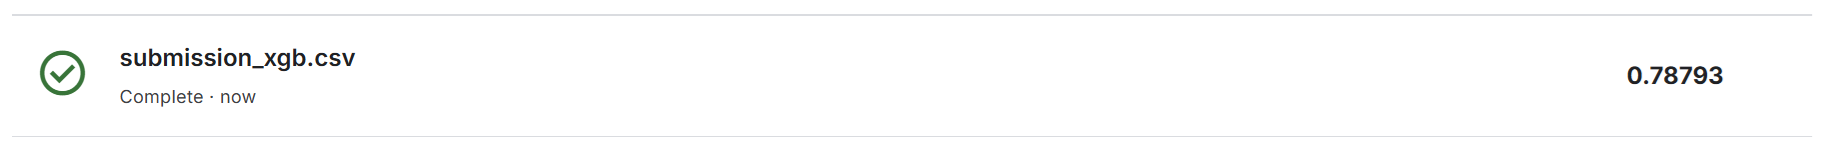